# SimpleImputer: different procedures on different features

## Mean / Median imputation

Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a **complete dataset** that can be used to train machine learning models.

Mean / median imputation consists of replacing all occurrences of missing values (NA) within a variable by the mean (if the variable has a Gaussian distribution) or median (if the variable has a skewed distribution).

**Note the following**:

- If a variable is normally distributed, the mean, median and mode, are approximately the same. Therefore, replacing missing values by the mean and the median are equivalent. Replacing missing data by the mode is not common practice for  numerical variables.
- If the variable is skewed, the mean is biased by the values at the far end of the distribution. Therefore, the median is a better representation of the majority of the values in the variable.
- For discrete variables casted as 'int' (to save memory), the mean may not be an integer, therefore the whole variable will be re-casted as 'float'. In order to avoid this behaviour, we can replace NA with the median instead. The median will inevitably be an integer / discrete value as well.


### Which variables can I impute with Mean / Median Imputation?

The mean and median can only be calculated on numerical variables, therefore these methods are suitable for continuous and discrete numerical variables only.


### Assumptions

- Data is missing completely at random (MCAR)
- The missing observations, most likely look like the majority of the observations in the variable (aka, the mean / median)

If data is missing completely at random, then it is fair to assume that the missing values, are most likely very close to the value of the mean or the median of the distribution, as these represent the most frequent / average observation.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)

### Limitations

- Distortion of the original variable distribution
- Distortion of the original variance
- Distortion of the covariance with the remaining variables of the dataset

When replacing NA with the mean or median, the variance of the variable will be distorted if the number of NA is big respect to the total number of observations, leading to underestimation of the variance.

In addition, estimates of covariance and correlations with other variables in the dataset may also be affected. Mean / median imputation may alter intrinsic correlations since the mean / median value that now replaces the missing data will not necessarily preserve the relation with the remaining variables.

Finally, concentrating all missing values at the mean / median value, may lead to observations that are common occurrences in the distribution, to be picked up as outliers.


### When to use mean / median imputation?

- Data is missing completely at random
- No more than 5% of the variable contains missing data

Although in theory, the above conditions should be met to minimise the impact of this imputation technique, in practice, mean / median imputation is very commonly used, even in those cases when data is not MCAR and there are a lot of missing values. The reason behind this, is the simplicity of the technique.


### Final note

Replacement of NA with mean / median is widely used in the data science community and in various data science competitions. See for example the winning solution of the KDD 2009 cup: ["Winning the KDD Cup Orange Challenge with Ensemble Selection"]( http://www.mtome.com/Publications/CiML/CiML-v3-book.pdf).

Typically, mean / median imputation is done together with adding a binary "missing indicator" variable to capture those observations where the data was missing (see lecture "Missing Indicator"), thus covering 2 angles: if the data was missing completely at random, this would be captured by the mean /median imputation, and if it wasn't this would be captured by the additional "missing indicator" variable. Both methods are extremely straight forward to implement, and therefore are a top choice in data science competitions.


We will perform mean and median imputation using pandas on the auto-mpg Datasets.


**A MASSIVE NOTE OF CAUTION**: when encoding the returned numpy arrays from Scikit-learn back to a dataframe, there is the potential risk of messing the order of the features and therefore MISS-REPRESENTING the data!!

You need to be extremely careful to pass the columns to the pd.DataFrame command in the same order in which they were in the X_train BEFORE the transformation!.

On occasions, we want to implement different imputation techniques to different features, how can we do this using the SimpleImputer from Scikit-learn?

We need to use another class called ColumnTransformer. 

**Note** ColumnTransformer has been recently released by Scikit-learn and it is therefore in beta version. This means that the developers can change the way it is used, or remove it altogether any time. The implication is that the code you write today, may not be useful after new releases from Scikit-learn. That is usually what happens with any open-source package when the developers are trying new functionality.

More details about the ColumnTransformer in the [Sklearn website](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# these are the objects we need to impute missing data
# with sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# to split the datasets
from sklearn.model_selection import train_test_split

# to show all the columns of the dataframe in the notebook
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('C:\\Users\\gusal\\machine learning\\Feature engineering\\auto-mpg.csv')

In [3]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,NaN,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,NaN,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,NaN,10.5,70,1,ford torino


In [4]:
data.isnull().sum()

mpg              0
cylinders        0
displacement     0
horsepower       6
weight           9
acceleration    33
model year       0
origin           0
car name         0
dtype: int64

The variables with missing data are:horsepower, wight and acceleration
therefore the imputation will be done to only these variables

In [5]:
inputs = data.drop(['mpg'], axis = 1)

In [6]:
target = data['mpg']

In [7]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    inputs,  # predictors
    target,  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((278, 8), (120, 8))

In [8]:
X_train.head(20)

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
230,8,350.0,170.0,4165.0,NaN,77,1,chevrolet monte carlo landau
357,4,119.0,100.0,2615.0,14.8,81,3,datsun 200sx
140,8,304.0,150.0,4257.0,15.5,74,1,amc matador (sw)
22,4,104.0,95.0,2375.0,17.5,70,2,saab 99e
250,8,318.0,140.0,3735.0,13.2,78,1,dodge diplomat
155,6,250.0,72.0,3158.0,19.5,75,1,ford maverick
356,4,108.0,75.0,2350.0,16.8,81,3,toyota corolla
216,4,98.0,68.0,2045.0,18.5,77,3,honda accord cvcc
186,4,101.0,83.0,2202.0,15.3,76,2,renault 12tl
281,6,200.0,85.0,2990.0,18.2,79,1,mercury zephyr 6


In [9]:
X_test.head(20)

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
65,8,351.0,153.0,4129.0,13.0,72,1,ford galaxie 500
132,4,140.0,75.0,2542.0,17.0,74,1,chevrolet vega
74,8,302.0,140.0,4294.0,16.0,72,1,ford gran torino (sw)
78,4,120.0,87.0,2979.0,NaN,72,2,peugeot 504 (sw)
37,6,232.0,100.0,NaN,15.5,71,1,amc matador
54,4,72.0,69.0,1613.0,NaN,71,3,datsun 1200
294,4,86.0,65.0,1975.0,15.2,79,3,maxda glc deluxe
60,4,140.0,90.0,2408.0,19.5,72,1,chevrolet vega
12,8,400.0,150.0,3761.0,9.5,70,1,chevrolet monte carlo
341,6,173.0,110.0,2725.0,12.6,81,1,chevrolet citation



### Imputation important

Imputation should be done over the training set, and then propagated to the test set. This means that the mean / median to be used to fill missing values both in train and test set, should be extracted from the train set only. And this is to avoid overfitting.

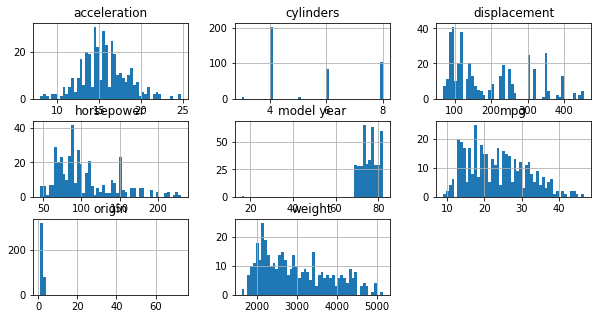

In [10]:
# let's look at the distributions of the variables to decide
# whether we use the mean or the median

data.hist(bins=50, figsize=(10,5))
plt.show()

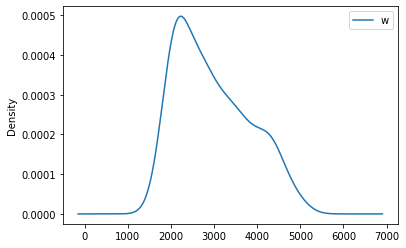

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
data['weight'].plot(kind='kde', ax=ax)
# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, 'weight', loc='best')

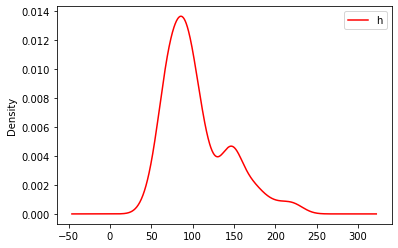

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

# variable imputed with the median
data['horsepower'].plot(kind='kde', ax=ax, color='red')
# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, 'horsepower', loc='best')

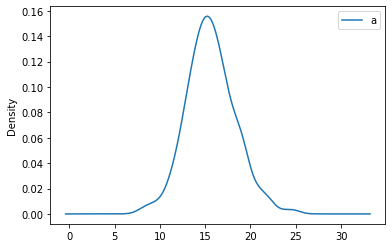

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

# variable imputed with the median
data['acceleration'].plot(kind='kde', ax=ax)

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, 'acceleration', loc='best')

### I will impute acceleration with the mean, and horsepower and weight with the median, as those variables are quite skewed.

In [14]:
# let's check the misssing data again
X_train.isnull().sum()

cylinders        0
displacement     0
horsepower       5
weight           6
acceleration    24
model year       0
origin           0
car name         0
dtype: int64

In [15]:
# first we need to make lists, indicating which features
# will be imputed with each method

numeric_features_mean = ['acceleration']
numeric_features_median = ['horsepower','weight']

# then we instantiate the imputers, within a pipeline
# we create one mean imputer and one median imputer
# by changing the parameter in the strategy

numeric_mean_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])

numeric_median_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

# then we put the features list and the transformers together
# using the column transformer

# we need to add remainder = True to indicate what we want
# ALL the columns returned at the end of the transformation
# and not just the engineered ones, which is the default
# behaviour of ColumnTransformer. 

preprocessor = ColumnTransformer(transformers=[
    ('mean_imputer', numeric_mean_imputer, numeric_features_mean),
    ('median_imputer', numeric_median_imputer, numeric_features_median)
], remainder='passthrough')


# parameters of the ColumnTransformer
# remainder = 'passthrough' indicates that we want to retain ALL the columns in the dataset
            # otherwise only those specified in the imputing steps will be kept
    
# for more details follow the sklearn page:
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

In [16]:
# now we fit the preprocessor
preprocessor.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('mean_imputer',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0))],
                                          verbose=False),
                                 ['acceleration']),
                                ('median_imputer',
                                 Pipeline(memory=None,
             

In [17]:
# we can explore the transformers like this:

preprocessor.transformers

[('mean_imputer', Pipeline(memory=None,
           steps=[('imputer',
                   SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                                 missing_values=nan, strategy='mean',
                                 verbose=0))],
           verbose=False), ['acceleration']),
 ('median_imputer', Pipeline(memory=None,
           steps=[('imputer',
                   SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                                 missing_values=nan, strategy='median',
                                 verbose=0))],
           verbose=False), ['horsepower', 'weight'])]

In [18]:
# and we can look at the parameters learned like this:

# for the mean imputer
preprocessor.named_transformers_['mean_imputer'].named_steps['imputer'].statistics_

array([15.68307087])

In [19]:
# and we can corroborate the value with that one in
# the train set
X_train[numeric_features_mean].mean()

acceleration    15.683071
dtype: float64

In [20]:
# for the median imputerthere are 2 values learnt
# because we want to impute 2 different variables

preprocessor.named_transformers_['median_imputer'].named_steps['imputer'].statistics_

array([  95., 2845.])

In [21]:
# and we corroborate those values in the train set
X_train[numeric_features_median].median()

horsepower      95.0
weight        2845.0
dtype: float64

In [22]:
# When we apply preprocessor.transform(X_train) we obtain an array, in order to encode the train set back 
# to a dataframe, we store the columns and the index.

X_columns_original = inputs.columns # the order of the columns has to be changed
X_index = X_train.index

In [23]:
X_test_index = X_test.index

In [24]:
# and now we can impute the data
X_train = preprocessor.transform(X_train)

# and check it worked
#np.mean(np.isnan(X_train))

In [25]:
X_train

array([[15.683070866141732, 170.0, 4165.0, ..., 77, 1,
        'chevrolet monte carlo landau'],
       [14.8, 100.0, 2615.0, ..., 81, 3, 'datsun 200sx'],
       [15.5, 150.0, 4257.0, ..., 74, 1, 'amc matador (sw)'],
       ...,
       [19.5, 49.0, 1867.0, ..., 73, 2, 'fiat 128'],
       [15.0, 100.0, 3282.0, ..., 71, 1, 'pontiac firebird'],
       [16.5, 71.0, 2223.0, ..., 75, 2, 'volkswagen dasher']],
      dtype=object)

In [26]:
# the order of the columns has to be changed and the mpg column must be removed to match the columns of the array
X_columns_original

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin', 'car name'],
      dtype='object')

In [27]:
X_columns = ['acceleration','horsepower', 'weight','cylinders', 'displacement','model year', 'origin', 'car name']

In [28]:
# encode the train set back to a dataframe
X_train = pd.DataFrame(X_train,columns = X_columns, index = X_index )

In [29]:
X_train

,acceleration,horsepower,weight,cylinders,displacement,model year,origin,car name
230,15.6831,170,4165,8,350,77,1,chevrolet monte carlo landau
357,14.8,100,2615,4,119,81,3,datsun 200sx
140,15.5,150,4257,8,304,74,1,amc matador (sw)
22,17.5,95,2375,4,104,70,2,saab 99e
250,13.2,140,3735,8,318,78,1,dodge diplomat
...,...,...,...,...,...,...,...,...
323,14.4,105,2800,4,156,80,1,dodge colt
192,14.5,105,3353,6,250,76,1,chevrolet nova
117,19.5,49,1867,4,68,73,2,fiat 128
47,15,100,3282,6,250,71,1,pontiac firebird


In [30]:
# ordening the columns as it was originally
X_train = X_train[X_columns_original]

In [31]:
X_train.head(20)

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
230,8,350,170,4165,15.6831,77,1,chevrolet monte carlo landau
357,4,119,100,2615,14.8,81,3,datsun 200sx
140,8,304,150,4257,15.5,74,1,amc matador (sw)
22,4,104,95,2375,17.5,70,2,saab 99e
250,8,318,140,3735,13.2,78,1,dodge diplomat
155,6,250,72,3158,19.5,75,1,ford maverick
356,4,108,75,2350,16.8,81,3,toyota corolla
216,4,98,68,2045,18.5,77,3,honda accord cvcc
186,4,101,83,2202,15.3,76,2,renault 12tl
281,6,200,85,2990,18.2,79,1,mercury zephyr 6


In [32]:
# checking there are no null values
X_train.isnull().sum()

cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [33]:
# and now we can impute the test data
X_test = preprocessor.transform(X_test)


In [34]:
X_test = pd.DataFrame(X_test,columns = X_columns, index = X_test_index )

In [35]:
X_test.head()

,acceleration,horsepower,weight,cylinders,displacement,model year,origin,car name
65,13,153,4129,8,351,72,1,ford galaxie 500
132,17,75,2542,4,140,74,1,chevrolet vega
74,16,140,4294,8,302,72,1,ford gran torino (sw)
78,15.6831,87,2979,4,120,72,2,peugeot 504 (sw)
37,15.5,100,2845,6,232,71,1,amc matador


In [36]:
X_test = X_test[X_columns_original]

In [37]:
X_test.head(20)

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
65,8,351,153,4129,13,72,1,ford galaxie 500
132,4,140,75,2542,17,74,1,chevrolet vega
74,8,302,140,4294,16,72,1,ford gran torino (sw)
78,4,120,87,2979,15.6831,72,2,peugeot 504 (sw)
37,6,232,100,2845,15.5,71,1,amc matador
54,4,72,69,1613,15.6831,71,3,datsun 1200
294,4,86,65,1975,15.2,79,3,maxda glc deluxe
60,4,140,90,2408,19.5,72,1,chevrolet vega
12,8,400,150,3761,9.5,70,1,chevrolet monte carlo
341,6,173,110,2725,12.6,81,1,chevrolet citation


In [38]:
X_test.isnull().sum()

cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

**ANOTHER NOTE OF CAUTION**

ColumnTransformer is in essence just slicing the dataframe in the required features. Then the SimpleImputer operates on the sliced dataframe. If different features are required by the different imputation methods, it will slice the dataframe on the required features for each imputation, and then concatenate them to produce the final output.

For our specific example, what happens is the following:

- ColumnTransformer first creates a single column dataframe with the first feature, acceleration
- ColumnTransformer creates a 2 column dataframe with the features horsepower and weight
- ColumnTransformer creates an additional dataframe with the remaining features in the train set
- The SimpleImputers learn the parameters in their respective sliced dataframes
- ColunmnTransformer contatenates back all the dataframes into the final result